In [1]:
%matplotlib inline
# %%capture
# python libraties
import os, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob import glob
from PIL import Image
import time
import copy
# pytorch libraries
import torch
import torch.nn.functional as F
from torch import optim,nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models,transforms, utils


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# data directory 
data_dir = 'data'   

In [38]:
def set_parameter_requires_grad(model, finetuning = False):
    '''
        This function freezes the parameters of the model.
        
        Parameters:
            model: model to be freezed before training
            finetuning: if finetuning is true then the model will not be freezed
        
        Returns:
            Nothing
    '''
    if not finetuning:
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = False
    else: 
        print(finetuning)
        for param in model.parameters():
            param.requires_grad = True

In [39]:
class FCModel(nn.Module):
    def __init__(self, num_ftrs, output_ftrs):
        
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(num_ftrs, 128)
#         self.fc2 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_ftrs)
#         self.drop1 = nn.Dropout(0.2)
#         self.drop2 = nn.Dropout(0.2)
        
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = self.drop1(x)
#         x = F.relu(self.fc2(x))
#         x = self.drop2(x)
        x = self.fc2(x)
        return self.softmax(x)
        

In [51]:
def initialize_models(model_name, num_classes = 7, fine_tuning = False):
    '''
        This function initialize3s the pretrained model
    '''
    
    model_fe = None
    input_size = 0
    
    if(model_name == 'resnet'):
        model_fe = models.resnet50(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.fc.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
        model_fe.fc = FCModel(num_ftrs, num_classes)
#         model_fe.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif(model_name == 'densenet'):
        model_fe = models.densenet121(pretrained = True)
        set_parameter_requires_grad(model_fe, fine_tuning)
        num_ftrs = model_fe.classifier.in_features
#         hidden_ftrs1 = model_fe.fc.out_features
#         hidden_ftrs2 = int(hidden_ftrs1 / 2)
#         model_fe.classifier = FCModel(num_ftrs, num_classes)
        model_fe.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    return model_fe, input_size
        

In [4]:
device = torch.device('cuda:0')
# Put the model on the device:
# model = model.to(device)
# device
# models.densenet121()

In [9]:
# mean = np.load('means.npz')
# stdevs = np.load('stdevs.npz')
# norm_mean = mean['arr_0']
# norm_std = stdevs['arr_0']
# print(norm_mean)
# print(norm_std)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [54]:
# optimizer = optim.Adam(model.fc.parameters(), lr = 0.0001)
# criterion = nn.CrossEntropyLoss().to(device)
# import pandas as pd
# df = pd.read_csv('data/validation.csv')
# df.shape[0]
size = {
    'train': 28428,
    'val' : 3309
}

In [68]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, best_acc = 0.0):
    since = time.time()
    
    val_acc, val_loss = [],[]
    train_acc, train_loss = [],[]
    lr_rate = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 print('phase train')
                for param_group in optimizer.param_groups:
                    print('Learning Rate {}'.format(param_group['lr']))
                    lr_rate.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
#                 print('phase val')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            del inputs
            del labels
            torch.cuda.empty_cache()
                
            if phase == 'train':
                scheduler.step(loss)

            epoch_loss = running_loss / size[phase]
            epoch_acc = running_corrects.double() / size[phase]
            
            if phase == 'train':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc, best_acc

In [69]:
model, input_size = initialize_models('densenet', num_classes = 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',patience=3, verbose = True)
# # torch.cuda.empty_cache()
# models.densenet121()

False


In [70]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
# transfromations for train images
input_size = 224
train_transform = transforms.Compose([transforms.Resize(input_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize(input_size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [11]:
# del model
torch.cuda.empty_cache()

In [12]:
class HamDataset(Dataset):
    def __init__(self, csvpath, transform = None):
        self.df = pd.read_csv(csvpath)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        
        if self.transform:
            X = self.transform(X)
        
        return X, y

def get_data_loader(csvpath, transform = test_transform, batch_size = 32):
    if csvpath == 'train.csv':
        transform = train_transform
    csvpath = os.path.join(data_dir, csvpath)
    dataset = HamDataset(csvpath, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return dataloader

In [13]:
# train_dl = get_data_loader('train.csv')
dataloader = {'train': get_data_loader('train.csv'),
           'val': get_data_loader('validation.csv')}

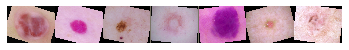

<Figure size 1440x720 with 0 Axes>

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    plt.figure(figsize=(20,10))
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch
inputs = inputs[:7]
classes = classes[:7]
out = utils.make_grid(inputs)

imshow(out, title=classes)
classes

In [76]:
best_acc = 0
print(best_acc)

0


In [77]:
# optimizer = optim.SGD(model.fc.parameters(), lr=1.0e-3, momentum = 0.9)
# use Adam in next phase
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
model, val_loss, val_acc, train_loss, train_acc, best_acc = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
Learning Rate 0.001



train Loss: 1.2040 Acc: 0.5560



val Loss: 0.6614 Acc: 0.7906

Epoch 1/24
----------
Learning Rate 0.001



train Loss: 0.9959 Acc: 0.6317



val Loss: 0.6932 Acc: 0.7661

Epoch 2/24
----------
Learning Rate 0.001



train Loss: 0.9501 Acc: 0.6502



val Loss: 0.5396 Acc: 0.8253

Epoch 3/24
----------
Learning Rate 0.001



train Loss: 0.9223 Acc: 0.6623



val Loss: 0.5956 Acc: 0.8011

Epoch 4/24
----------
Learning Rate 0.001



train Loss: 0.9093 Acc: 0.6627



val Loss: 0.5017 Acc: 0.8326

Epoch 5/24
----------
Learning Rate 0.001



train Loss: 0.8966 Acc: 0.6648



val Loss: 0.6215 Acc: 0.7903

Epoch 6/24
----------
Learning Rate 0.001



train Loss: 0.8874 Acc: 0.6711



val Loss: 0.5280 Acc: 0.8196

Epoch 7/24
----------
Learning Rate 0.001



train Loss: 0.8848 Acc: 0.6719



val Loss: 0.4779 Acc: 0.8398

Epoch 8/24
----------
Learning Rate 0.001



Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
train Loss: 0.8868 Acc: 0.6688



val Loss: 0.4810 Acc: 0.8383

Epoch 9/24
----------
Learning Rate 0.0001



train Loss: 0.8490 Acc: 0.6870



val Loss: 0.5839 Acc: 0.8002

Epoch 10/24
----------
Learning Rate 0.0001



train Loss: 0.8411 Acc: 0.6849



val Loss: 0.5235 Acc: 0.8214

Epoch 11/24
----------
Learning Rate 0.0001



train Loss: 0.8389 Acc: 0.6898



val Loss: 0.5371 Acc: 0.8157

Epoch 12/24
----------
Learning Rate 0.0001



Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
train Loss: 0.8340 Acc: 0.6896



val Loss: 0.5095 Acc: 0.8296

Epoch 13/24
----------
Learning Rate 1e-05



train Loss: 0.8349 Acc: 0.6896



val Loss: 0.5615 Acc: 0.8105

Epoch 14/24
----------
Learning Rate 1e-05



train Loss: 0.8280 Acc: 0.6917



val Loss: 0.5273 Acc: 0.8241

Epoch 15/24
----------
Learning Rate 1e-05



train Loss: 0.8339 Acc: 0.6900



val Loss: 0.5586 Acc: 0.8081

Epoch 16/24
----------
Learning Rate 1e-05



train Loss: 0.8406 Acc: 0.6867



val Loss: 0.5083 Acc: 0.8286

Epoch 17/24
----------
Learning Rate 1e-05



Epoch    18: reducing learning rate of group 0 to 1.0000e-06.
train Loss: 0.8310 Acc: 0.6912



val Loss: 0.5304 Acc: 0.8181

Epoch 18/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 0.8325 Acc: 0.6915



val Loss: 0.5264 Acc: 0.8223

Epoch 19/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 0.8333 Acc: 0.6899



val Loss: 0.5451 Acc: 0.8123

Epoch 20/24
----------
Learning Rate 1.0000000000000002e-06



train Loss: 0.8291 Acc: 0.6928



val Loss: 0.5094 Acc: 0.8296

Epoch 21/24
----------
Learning Rate 1.0000000000000002e-06



Epoch    22: reducing learning rate of group 0 to 1.0000e-07.
train Loss: 0.8327 Acc: 0.6892



val Loss: 0.5432 Acc: 0.8150

Epoch 22/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 0.8374 Acc: 0.6900



val Loss: 0.5242 Acc: 0.8241

Epoch 23/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 0.8298 Acc: 0.6930



val Loss: 0.5245 Acc: 0.8223

Epoch 24/24
----------
Learning Rate 1.0000000000000002e-07



train Loss: 0.8330 Acc: 0.6895



val Loss: 0.5247 Acc: 0.8214

Training complete in 546m 53s
Best val Acc: 0.839831


In [78]:
# state = {
#     'epochs' : 35,
#     'model state dict' : model.state_dict(),
#     'optimizer state dict' : optimizer.state_dict()
# #     'val accuracy': best_val_acc
# }

torch.save(model, 'models/densenet121.pth')


In [79]:
# for x in val_loss:
#     total_val_loss.sppend(x)
# for x in val_acc:
#     total_val_acc.sppend(x)
# for x in train_loss:
#     total_train_loss.sppend(x)
# for x in train_acc:
#     total_train_acc
    

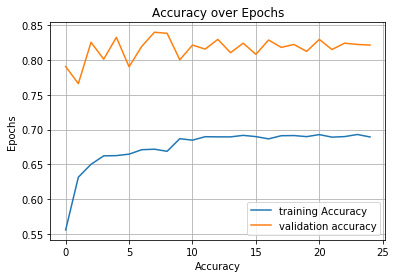

In [80]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title('Accuracy over Epochs') 
plt.plot(val_acc, label = 'training Accuracy')
plt.plot(train_acc, label = 'validation accuracy')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/accuracy-resnet50ft.png')
plt.legend()
plt.show()

In [81]:
# val_acc

In [82]:
# train_acc

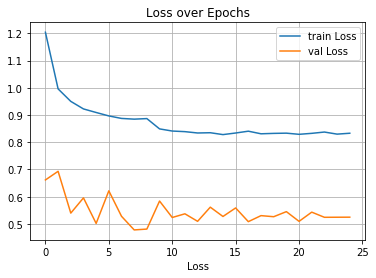

In [83]:
# fig = plt.figure(num = 2)
# fig1 = fig.add_subplot(2,1,1)
# fig2 = fig.add_subplot(2,1,2)
plt.xlabel('Loss')
plt.title('Loss over Epochs')
plt.plot(val_loss, label = 'train Loss')
plt.plot(train_loss, label = 'val Loss')
plt.grid()
# fig2.plot(total_loss_val, label = 'validation acc')
# fig2.plot(total_loss_train, label = 'training accuracy')
plt.savefig('graphs/loss-resnet50ft.png')
plt.legend()
plt.show()

In [70]:
# val_loss

In [71]:
# train_loss

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('graphs/conf_mat.png')
    plt.show()

In [14]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for images, labels in tqdm(dataloader['val']):
#         images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)

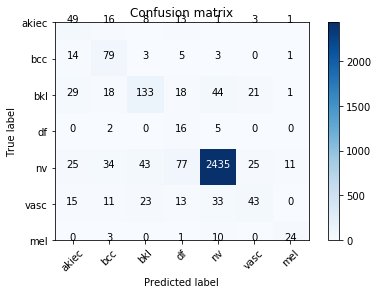

In [20]:
plot_confusion_matrix(confusion_mtx, plot_labels)

In [18]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.37      0.54      0.44        91
         bcc       0.48      0.75      0.59       105
         bkl       0.63      0.50      0.56       264
          df       0.11      0.70      0.19        23
          nv       0.96      0.92      0.94      2650
        vasc       0.47      0.31      0.37       138
         mel       0.63      0.63      0.63        38

    accuracy                           0.84      3309
   macro avg       0.52      0.62      0.53      3309
weighted avg       0.87      0.84      0.85      3309

